<a href="https://colab.research.google.com/github/JRopes/CrystalEnergyPredictionWithInvariants/blob/main/DF_T2L_C_DNN_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SETUP**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab_Notebooks/Dissertation/Prediction_Prototyping') 

In [ ]:
!pip install ipython-autotime

**IMPORTING LIBRARY DEPENDENCIES**

In [ ]:
import numpy as np
import pickle
import math
import pandas as pd
import datetime, os
import matplotlib.pyplot as plt

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
from keras.losses import Huber
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [ ]:
import DataImporter
import DataPreprocessing

In [ ]:
%load_ext tensorboard
%load_ext autotime

time: 99.5 µs (started: 2021-05-06 18:23:31 +00:00)


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

time: 149 ms (started: 2021-05-06 18:23:31 +00:00)


**IMPORTING DATA**

In [ ]:
feature_dir_path = '/content/drive/MyDrive/Colab_Notebooks/Dissertation/Data/T2L'
label_file_path = '/content/drive/MyDrive/Colab_Notebooks/Dissertation/Data/T2L_density_energy.csv' 

(feature_data, label_data, x_labels) = DataImporter.DataFrameImport(feature_dir_path,label_file_path)

File with greatest Domain: T2L_Centres_03386.csv || Number of Density Functions: 8
time: 22min 56s (started: 2021-05-06 18:23:31 +00:00)


In [ ]:
feature_data = DataPreprocessing.DataFiller(feature_data,feature_data[1,1,0],feature_data[1,0,200])

time: 3.88 s (started: 2021-05-06 18:46:28 +00:00)


In [ ]:
pickle.dump(feature_data, open("feature_data_dnn.p", "wb"))

pickle.dump(label_data, open("label_data_dnn.p","wb"))

time: 169 ms (started: 2021-05-06 18:46:32 +00:00)


In [ ]:
def data():

  feature_data = pickle.load(open("feature_data_dnn.p","rb"))
  label_data = pickle.load(open("label_data_dnn.p","rb"))

  shape = feature_data.shape

  serial_feature_data = np.zeros((shape[0],(shape[1] * shape[2])))

  df_length = np.ma.size(feature_data,2)

  for i in range(shape[0]):
    for j in range(shape[1]):
      for z in range(shape[2]):
              
        serial_feature_data[i,((j * df_length) + z)] = feature_data[i,j,z]


  pure_label_data = np.zeros((len(label_data)))

  for i in range(len(label_data)):
    pure_label_data[i] = label_data[i][1]

  serial_feature_data = np.nan_to_num(serial_feature_data)

  ## Standard Scaler
  feature_scaler = preprocessing.StandardScaler()

  X_scaled = (feature_scaler.fit_transform(serial_feature_data))
  y_scaled = pure_label_data.reshape(-1,1)

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, shuffle=True)

  return X_train, y_train, X_test, y_test

time: 24 ms (started: 2021-05-06 18:46:32 +00:00)


**ARCHITECTURE**

In [ ]:
def load_model():
  model = Sequential()

  #Input Layer and Hidden Layer 1
  model.add(Dense(2048, input_dim=2104, activation='sigmoid', name='Dense_Layer_01', kernel_initializer=glorot_uniform()))
  model.add(Dropout(0.1, name='Dropout_Layer_01'))

  #Hidden Layer 2
  model.add(Dense(1024, activation='sigmoid', name='Dense_Layer_02', kernel_initializer=glorot_uniform()))
  model.add(Dropout(0.3, name='Dropout_Layer_02'))

  #Output Layer
  model.add(Dense(1, activation='linear', name='Dense_Output_Layer_04', kernel_initializer=glorot_uniform()))

  model.compile(loss='huber_loss', optimizer=Adam(learning_rate=0.01), metrics=["mae","mape"])

  return model

time: 11.9 ms (started: 2021-05-06 18:46:32 +00:00)


**TRAINING**

In [ ]:
X_train, y_train, X_test, y_test = data()

time: 5.19 s (started: 2021-05-06 18:46:32 +00:00)


In [ ]:
model = load_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer_01 (Dense)       (None, 2048)              4311040   
_________________________________________________________________
Dropout_Layer_01 (Dropout)   (None, 2048)              0         
_________________________________________________________________
Dense_Layer_02 (Dense)       (None, 1024)              2098176   
_________________________________________________________________
Dropout_Layer_02 (Dropout)   (None, 1024)              0         
_________________________________________________________________
Dense_Output_Layer_04 (Dense (None, 1)                 1025      
Total params: 6,410,241
Trainable params: 6,410,241
Non-trainable params: 0
_________________________________________________________________
None
time: 201 ms (started: 2021-05-06 18:46:37 +00:00)


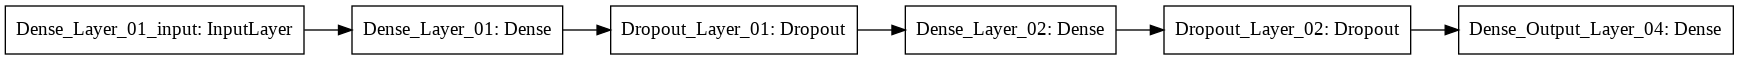

time: 526 ms (started: 2021-05-06 18:46:37 +00:00)


In [ ]:
plot_model(model, to_file='model.png', rankdir='LR')

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

time: 28.7 ms (started: 2021-05-06 18:46:38 +00:00)


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True, verbose=1)

time: 3.47 ms (started: 2021-05-06 18:46:38 +00:00)


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_split=0.1, callbacks=[tensorboard_callback, es])

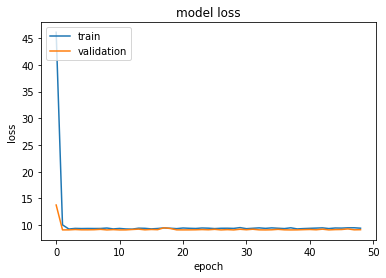

time: 211 ms (started: 2021-05-06 18:50:30 +00:00)


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

time: 4.54 s (started: 2021-05-06 18:50:30 +00:00)


**EVALUATION**

In [ ]:
predictions = model.predict(X_test)

time: 344 ms (started: 2021-05-06 18:50:35 +00:00)


In [ ]:
average_loss = 0
average_loss_percentage = 0
average_loss_percentage_rel_range = 0
counter = 0
rms = 0

error_ranges = np.array((0,0,0,0,0,0))

max_value = -999999.99
min_value = 999999.99

for label in y_test:
    if(label > max_value):
        max_value = label
        
    if(label < min_value):
        min_value = label
        
label_range = abs(max_value - min_value)


for i,prediction in enumerate(predictions):
    ##print("Prediction: " + str(prediction))
    ##print("Label: " + str(y_test[i]))
    ##print("Absolute Error: " + str(abs(prediction - y_test[i])))
    percentage_difference = abs((abs(prediction - y_test[i]) / y_test[i]) * 100)
    ##print("Absolute Percentage Error: " + str(percentage_difference) + "%")
    percentage_difference2 = abs((abs(prediction - y_test[i]) / label_range) * 100)
    ##print("Absolute Percentage Error relative to Label Range: " + str(percentage_difference2) + "%")
    ##print()
    loss = abs(prediction - y_test[i])
    average_loss += loss

    rms += loss**2

    if(loss <= 1.0):
      error_ranges[0] += 1
    elif(loss <= 2.0):
      error_ranges[1] += 1
    elif(loss <= 4.0):
      error_ranges[2] += 1
    elif(loss <= 8.0):
      error_ranges[3] += 1
    elif(loss <= 10.0):
      error_ranges[4] += 1
    else:
      error_ranges[5] += 1

    average_loss_percentage += percentage_difference
    average_loss_percentage_rel_range += percentage_difference2
    counter += 1

rms = math.sqrt(rms / counter)

print()
print("-=-=-=-=-=-=-=-=-")
print("SUMMARY:")
print("-=-=-=-=-=-=-=-=-")
print("Root Mean Squared Error: " + str(rms))
print("Mean Absolute Error: " + str(average_loss / counter))
print("Mean Absolute Percentage Error: " + str(average_loss_percentage / counter) + "%")
print("Mean Absolute Percentage Error relative to Label Range: " + str(average_loss_percentage_rel_range / counter) + "%")
print("Accuracy: " + str(100 - (average_loss_percentage / counter)) + "%")
print()
print("BREAKDOWN:")
print("   Error <= 1.0 kJ/mol: " + str(error_ranges[0]) + " or " + str((error_ranges[0] / counter) * 100) + "% of Test Set")
print("   Error <= 2.0 kJ/mol: " + str(error_ranges[1]) + " or " + str((error_ranges[1] / counter) * 100) + "% of Test Set")
print("   Error <= 4.0 kJ/mol: " + str(error_ranges[2]) + " or " + str((error_ranges[2] / counter) * 100) + "% of Test Set")
print("   Error <= 8.0 kJ/mol: " + str(error_ranges[3]) + " or " + str((error_ranges[3] / counter) * 100) + "% of Test Set")
print("   Error <= 10.0.0 kJ/mol: " + str(error_ranges[4]) + " or " + str((error_ranges[4] / counter) * 100) + "% of Test Set")
print("   Error > 10.0 kJ/mol: " + str(error_ranges[5]) + " or " + str((error_ranges[5] / counter) * 100) + "% of Test Set")